<a href="https://colab.research.google.com/github/AyazNakhudaGitHub/BERT_Customer_Reviews_Classification/blob/main/Experiments/3_category_experiments/3_category_summarized_text_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Summarized Review Texts and 3 categories**

In this model we experiement with the summarized versions of the customer review text. These texts will be classified into 3 categories.

In [ ]:
!pip install -q tf-models-official==2.4.0

     |████████████████████████████████| 1.1 MB 8.5 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 213 kB 65.2 MB/s 
     |████████████████████████████████| 1.2 MB 51.0 MB/s 
     |████████████████████████████████| 1.1 MB 55.1 MB/s 
     |████████████████████████████████| 352 kB 78.1 MB/s 
     |████████████████████████████████| 47.6 MB 1.2 MB/s 
     |████████████████████████████████| 99 kB 11.2 MB/s 
     |████████████████████████████████| 596 kB 58.7 MB/s 


In [ ]:
!pip install -q -U tensorflow-text

     |████████████████████████████████| 4.9 MB 9.7 MB/s 


In [ ]:
import os
import urllib, json

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
from tensorflow.keras.utils import to_categorical

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16196949819734887589
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16347916203993861997
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading in the pretrained model.

In [ ]:
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In this case we had the data saved to numpy arrays and so these were simply loaded in.

In [ ]:
# load in the saved numpy arrays
x_train = np.load('trainx.npy',allow_pickle=True)
x_val = np.load('valx.npy',allow_pickle=True)
x_test = np.load('testx.npy',allow_pickle=True)

y_train = np.load('trainy.npy',allow_pickle=True)
y_val = np.load('valy.npy',allow_pickle=True)
y_test = np.load('testy.npy',allow_pickle=True)

In [ ]:
print(x_train.shape)

(29600,)


In [ ]:
y = np.concatenate((y_test,y_val,y_train), axis=0)

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)

encoded_Y_train = encoder.transform(y_train)
encoded_Y_val = encoder.transform(y_val)
encoded_Y_test = encoder.transform(y_test)


# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = to_categorical(encoded_Y_test)
dummy_y_val = to_categorical(encoded_Y_val)
dummy_y_train = to_categorical(encoded_Y_train)

Tokenization and the head+tail token selection is done here.

In [ ]:
def encode_names(n):
   
   tokens = list(tokenizer.tokenize(n)[:127]+tokenizer.tokenize(n)[-381:]).
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

reviews = tf.ragged.constant([
    encode_names(n) for n in x_train])

In [ ]:
print('Tokenized reviews shape', reviews.shape.as_list())

Tokenized reviews shape [29600, None]


In [ ]:
x_train[0]

'This is not easy to use - child seat belt straps are very difficult to adjust'

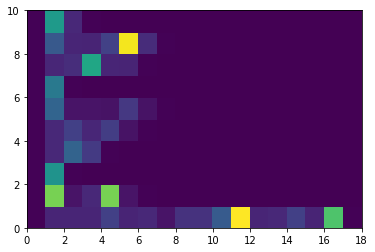

In [ ]:

cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*reviews.shape[0]
input_word_ids = tf.concat([cls, reviews], axis=-1)
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

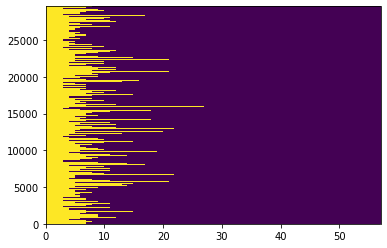

In [ ]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

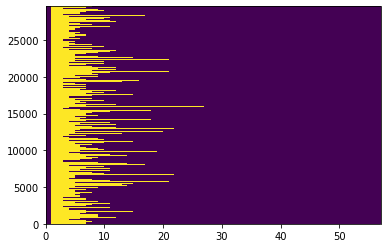

In [ ]:
type_cls = tf.zeros_like(cls)
type_review = tf.ones_like(reviews)
input_type_ids = tf.concat([type_cls, type_review], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [ ]:
lens = [len(i) for i in input_word_ids]

max_seq_length = max(lens)
print('Max length is:', max_seq_length)

Max length is: 57


In [ ]:
max_seq_length = int(1.5*max_seq_length)
print('Max length is:', max_seq_length)

Max length is: 85


In [ ]:

def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))



  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

The BERT encoding is done below:

In [ ]:

X_train = bert_encode(x_train, tokenizer, max_seq_length)    
X_val = bert_encode(x_val, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

In [ ]:
epochs = 3  
batch_size = 8 
eval_batch_size = batch_size
LR = 2e-6

train_data_size = len(y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

In [ ]:

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")                               

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids]) 
flatten = tf.keras.layers.Flatten(name='flatten')
output_flatten = flatten(pooled_output)                                 
output = tf.keras.layers.Dropout(rate=0.1)(output_flatten) 
output = tf.keras.layers.Dense(3, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)


In [ ]:
pooled_output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [ ]:
import tensorflow_addons as tfa

In [ ]:
model.compile(tfa.optimizers.RectifiedAdam(learning_rate=LR, beta_1= 0.8, beta_2=0.8), # try sgd  
              loss='categorical_crossentropy',
              metrics=['accuracy'],
  
              )

As you can see, a shallow model is being used.

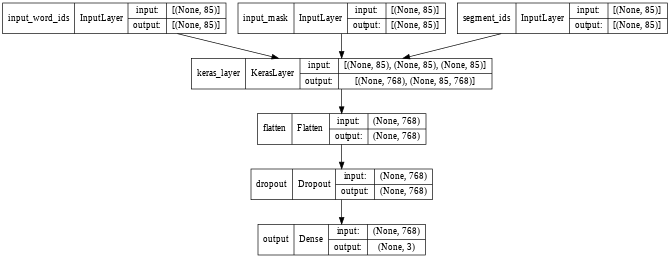

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 85)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 85)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 85)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 85, 768)]                 'input_mask[0][0]',         

In [ ]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, dummy_y_val),
                    verbose=1)

Epoch 1/3
3700/3700 [==============================] - 535s 139ms/step - loss: 0.8489 - accuracy: 0.6040 - val_loss: 0.7468 - val_accuracy: 0.6668
Epoch 2/3
3700/3700 [==============================] - 514s 139ms/step - loss: 0.7359 - accuracy: 0.6739 - val_loss: 0.7283 - val_accuracy: 0.6805
Epoch 3/3
3700/3700 [==============================] - 515s 139ms/step - loss: 0.6951 - accuracy: 0.6951 - val_loss: 0.7176 - val_accuracy: 0.6832


In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

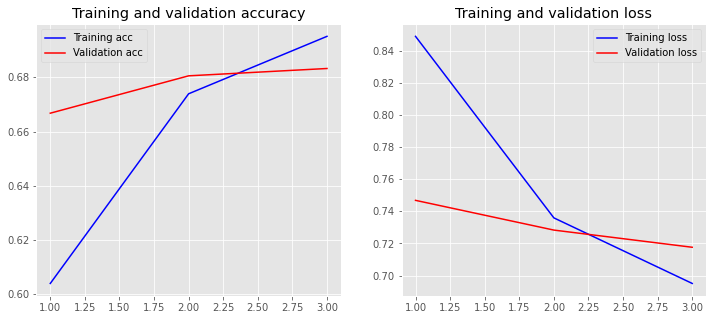

In [ ]:
plot_history(history)

In [ ]:
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.6759


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test, batch_size=1, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1) + 1
print(classification_report(y_test, y_pred_bool, labels=[1,2,3], digits=4))



3700/3700 [==============================] - 32s 9ms/step
              precision    recall  f1-score   support

           1     0.6838    0.7411    0.7113      1205
           2     0.5634    0.4511    0.5010      1073
           3     0.7322    0.7904    0.7602      1422

    accuracy                         0.6759      3700
   macro avg     0.6598    0.6609    0.6575      3700
weighted avg     0.6675    0.6759    0.6691      3700



In [ ]:
model_fname = 'Ratings_BERT_Summary_3cat_run2'
my_wd = '/content/drive/My Drive'

model.save(os.path.join(my_wd, model_fname))

INFO:tensorflow:Assets written to: /content/drive/My Drive/Ratings_BERT_Summary_3cat_run2/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Ratings_BERT_Summary_3cat_run2/assets


For the upcoming section of this notebook we utilize T-SNE to visualize our data.

In [ ]:
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                 outputs=model.get_layer('flatten').output)

In [ ]:
sentence_embedded = intermediate_layer_model.predict(X_train)

In [ ]:
labels_rating = y

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

X = list(sentence_embedded)

X_embedded = TSNE(n_components=2).fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
df_embeddings = pd.DataFrame(X_embedded)
df_embeddings = df_embeddings.rename(columns={0:'x',1:'y'})
df_embeddings = df_embeddings.assign(label=y_train)

In [ ]:
df_embeddings = df_embeddings.assign(text=x_train)

In [ ]:
import plotly.express as px

fig = px.scatter(
    df_embeddings, x='x', y='y',
    color='label', labels={'color': 'label'},
    hover_data=['text'], title = 'Overall Ratings Embedding Visualization')
fig.show()

In [ ]:
df_embeddings['length_text'] = df_embeddings[['text']].applymap(lambda x : len(x))

In [ ]:
import plotly.express as px

fig = px.scatter(
    df_embeddings, x='x', y='y',
    color='label', labels={'color': 'label'},
    size = 'length_text', size_max = 10, template = 'simple_white',
    hover_data=['text'], title = 'Overall Ratings Embedding Visualization')
fig.show()

In [ ]:
#tf.keras.models.save_model(model, 'tsne_3cat_run_3')


In [ ]:
### it seems like the model is learning so let us continue the training for another 3 epochs making it 6 epochs in total

In [ ]:
history2 = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, dummy_y_val),
                    verbose=1)

Epoch 1/3
3700/3700 [==============================] - 514s 139ms/step - loss: 0.6582 - accuracy: 0.7139 - val_loss: 0.7222 - val_accuracy: 0.6886
Epoch 2/3
3700/3700 [==============================] - 514s 139ms/step - loss: 0.6283 - accuracy: 0.7293 - val_loss: 0.7500 - val_accuracy: 0.6876
Epoch 3/3
3700/3700 [==============================] - 515s 139ms/step - loss: 0.5963 - accuracy: 0.7469 - val_loss: 0.7665 - val_accuracy: 0.6895


In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

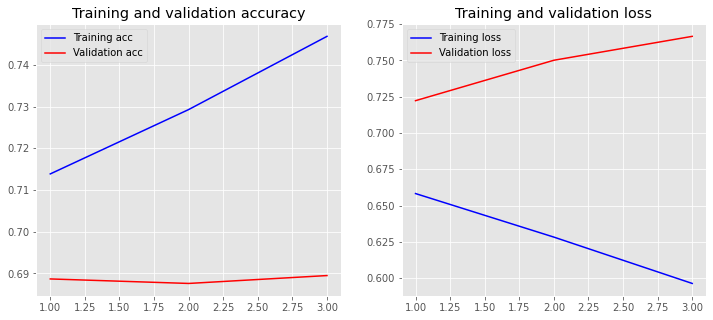

In [ ]:
plot_history(history2)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test, batch_size=1, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1) + 1
print(classification_report(y_test, y_pred_bool, labels=[1,2,3], digits=4))

3700/3700 [==============================] - 32s 9ms/step
              precision    recall  f1-score   support

           1     0.6981    0.7427    0.7197      1205
           2     0.5496    0.5163    0.5324      1073
           3     0.7631    0.7567    0.7599      1422

    accuracy                         0.6824      3700
   macro avg     0.6703    0.6719    0.6707      3700
weighted avg     0.6800    0.6824    0.6809      3700



In [ ]:
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.6824
